In [4]:
from pathlib import Path
import xml.etree.ElementTree as ET
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Extact ECG Signal and Relevant Metadata

In [5]:
def extract_ecg_data(root):
    # Define the namespace
    namespaces = {"ns": "urn:hl7-org:v3"}

    # Extract the sequence id and other sequence related metadata
    seq_id = root.find(".//ns:id", namespaces).attrib["root"]
    subject_id = root.find(".//ns:trialSubject/ns:id", namespaces).attrib["extension"]
    acq_time = root.find(".//ns:effectiveTime/ns:low", namespaces).attrib["value"]

    # Initialize a dictionary to hold the ECG data
    ecg_data = {
        "sequence_id": seq_id,
        "subject_id": subject_id,
        "acq_time": acq_time
    }

    # Extract the ECG signal, unit, and scale
    for component in root.findall(".//ns:sequenceSet/ns:component", namespaces)[1:13]:
        sequence = component.find(".//ns:sequence", namespaces)
        if sequence is not None:
            lead = sequence.find(".//ns:code", namespaces).attrib["code"]
            scale = float(sequence.find(".//ns:scale", namespaces).attrib["value"])
            signal = [int(x)*scale for x in sequence.find(".//ns:digits", namespaces).text.strip().split()]
        
            # Add each lead's signal to the data dictionary
            ecg_data[f'lead_{lead}'] = signal

    return ecg_data

In [6]:
data_path = Path("/media/nvme1/pbecg-data/fda")
all_ecg_data = []
for file_path in data_path.rglob("*xml"):
    tree = ET.parse(file_path)
    root = tree.getroot()
    ecg_data = extract_ecg_data(root)
    all_ecg_data.append(ecg_data)

df = pd.DataFrame(all_ecg_data)

In [7]:
# Fill NaN values in the first set of columns with values from the second set of columns
df['lead_MDC_ECG_LEAD_aVR'].fillna(df['lead_MDC_ECG_LEAD_AVR'], inplace=True)
df['lead_MDC_ECG_LEAD_aVL'].fillna(df['lead_MDC_ECG_LEAD_AVL'], inplace=True)
df['lead_MDC_ECG_LEAD_aVF'].fillna(df['lead_MDC_ECG_LEAD_AVF'], inplace=True)

# Drop the second set of columns
df.drop(columns=['lead_MDC_ECG_LEAD_AVR', 'lead_MDC_ECG_LEAD_AVL', 'lead_MDC_ECG_LEAD_AVF'], inplace=True)

In [8]:
# Convert the acquisition time to a datetime object
df["acq_time"] = pd.to_datetime(df["acq_time"], format="%Y%m%d%H%M%S")
# Store the dataset as a parquet file
save_path = Path("/media/nvme1/pbecg-data/signal.parquet")
df.to_parquet(save_path, index=False)

/home/bc299/miniconda3/envs/pb/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [9]:
df.head()

,sequence_id,subject_id,acq_time,lead_MDC_ECG_LEAD_I,lead_MDC_ECG_LEAD_II,lead_MDC_ECG_LEAD_III,lead_MDC_ECG_LEAD_aVR,lead_MDC_ECG_LEAD_aVL,lead_MDC_ECG_LEAD_aVF,lead_MDC_ECG_LEAD_V1,lead_MDC_ECG_LEAD_V2,lead_MDC_ECG_LEAD_V3,lead_MDC_ECG_LEAD_V4,lead_MDC_ECG_LEAD_V5,lead_MDC_ECG_LEAD_V6
0,aed392f4-2710-46ce-9292-c5e7f0351100,8353028527,2018-06-25 10:15:35,"[37.5, 43.75, 50.0, 56.25, 53.75, 50.0, 50.0, ...","[28.75, 37.5, 46.25, 56.25, 53.75, 50.0, 50.0,...","[-8.75, -6.25, -3.75, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-32.5, -40.0, -47.5, -56.25, -53.75, -50.0, -...","[22.5, 25.0, 26.25, 27.5, 26.25, 25.0, 25.0, 2...","[10.0, 15.0, 21.25, 27.5, 26.25, 25.0, 25.0, 2...","[-18.75, -12.5, -6.25, 0.0, 12.5, 25.0, 31.25,...","[-12.5, -12.5, -12.5, -12.5, 0.0, 12.5, 18.75,...","[-81.25, -75.0, -68.75, -62.5, -43.75, -25.0, ...","[-68.75, -75.0, -81.25, -87.5, -75.0, -62.5, -...","[-25.0, -25.0, -25.0, -25.0, -25.0, -25.0, -25...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.25,..."
1,a4c27939-0657-44a4-b675-aaefc5789df4,1369087047,2017-07-24 15:08:20,"[-23.75, 6.25, 2.5, 6.25, 8.75, 12.5, 12.5, 18...","[-31.25, 12.5, 12.5, 18.75, 25.0, 25.0, 31.25,...","[-7.5, 6.25, 10.0, 12.5, 16.25, 12.5, 18.75, 1...","[27.5, -8.75, -7.5, -12.5, -16.25, -18.75, -21...","[-8.75, 0.0, -3.75, -3.75, -3.75, 0.0, -3.75, ...","[-20.0, 8.75, 11.25, 15.0, 20.0, 18.75, 25.0, ...","[68.75, 50.0, 56.25, 50.0, 50.0, 50.0, 50.0, 6...","[43.75, 37.5, 31.25, 25.0, 18.75, 12.5, 18.75,...","[-43.75, -12.5, -18.75, -25.0, -18.75, -12.5, ...","[-137.5, -100.0, -100.0, -100.0, -100.0, -100....","[-112.5, -87.5, -87.5, -87.5, -87.5, -87.5, -9...","[-87.5, -62.5, -56.25, -50.0, -50.0, -50.0, -5..."
2,7a712d07-6c11-4873-8a02-f76e80af5064,6571810139,2018-09-04 12:53:53,"[-66.25, -75.0, -77.5, -81.25, -87.5, -93.75, ...","[-36.25, -25.0, -22.5, -18.75, -27.5, -25.0, -...","[30.0, 50.0, 55.0, 62.5, 60.0, 68.75, 50.0, 43...","[51.25, 50.0, 50.0, 50.0, 57.5, 60.0, 62.5, 66...","[-48.75, -62.5, -66.25, -72.5, -73.75, -81.25,...","[-3.75, 12.5, 16.25, 21.25, 16.25, 21.25, 6.25...","[25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25....","[43.75, 62.5, 62.5, 62.5, 62.5, 62.5, 62.5, 62...","[-18.75, -12.5, -12.5, -12.5, -6.25, 0.0, 0.0,...","[-18.75, 0.0, -6.25, -12.5, -12.5, -12.5, -12....","[-62.5, -37.5, -31.25, -37.5, -37.5, -37.5, -4...","[-25.0, -25.0, -31.25, -37.5, -31.25, -37.5, -..."
3,f1884aec-627a-43fa-bc1d-ba10d51915aa,1849085849,2018-11-09 10:22:28,"[41.25, 56.25, 65.0, 75.0, 75.0, 81.25, 81.25,...","[46.25, 68.75, 66.25, 56.25, 68.75, 87.5, 96.2...","[5.0, 12.5, 1.25, -18.75, -6.25, 6.25, 15.0, 2...","[-43.75, -62.5, -65.0, -65.0, -71.25, -83.75, ...","[17.5, 21.25, 31.25, 46.25, 40.0, 37.5, 32.5, ...","[25.0, 40.0, 33.75, 18.75, 31.25, 46.25, 55.0,...","[37.5, 37.5, 31.25, 37.5, 37.5, 50.0, 25.0, 25...","[6.25, 25.0, 25.0, 25.0, 31.25, 25.0, 18.75, 1...","[0.0, 25.0, 37.5, 37.5, 25.0, 25.0, 25.0, 25.0...","[-18.75, 12.5, 12.5, 12.5, 12.5, 0.0, 12.5, 0....","[-25.0, 0.0, 0.0, 0.0, 6.25, 12.5, -6.25, -12....","[-12.5, 0.0, 0.0, 0.0, 0.0, 0.0, -6.25, -12.5,..."
4,8496944c-ce99-4ae6-b272-e8aec8cef102,7517892706,2018-03-27 11:29:23,"[287.5, 293.75, 300.0, 306.25, 308.75, 312.5, ...","[243.75, 250.0, 256.25, 262.5, 262.5, 262.5, 2...","[-43.75, -43.75, -43.75, -43.75, -46.25, -50.0...","[-265.0, -271.25, -277.5, -283.75, -285.0, -28...","[165.0, 168.75, 171.25, 175.0, 177.5, 181.25, ...","[100.0, 102.5, 106.25, 108.75, 107.5, 106.25, ...","[-187.5, -187.5, -187.5, -187.5, -193.75, -200...","[-12.5, -12.5, -12.5, -12.5, -18.75, -25.0, -2...","[156.25, 162.5, 168.75, 175.0, 175.0, 175.0, 1...","[262.5, 262.5, 262.5, 262.5, 262.5, 262.5, 262...","[225.0, 225.0, 225.0, 225.0, 225.0, 225.0, 225...","[206.25, 212.5, 218.75, 225.0, 225.0, 225.0, 2..."


## Extract Labels

In [17]:
mort_path = Path("/media/nvme1/pbecg-data/mortara")
ecg_labels = []
for file_path in mort_path.rglob("*.xml"):
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Get the participant ID
    for demo in root.findall(".//DEMOGRAPHIC_FIELD"):
        label = demo.get("LABEL")
        value = demo.get("VALUE")
        if (label == "Participant #:") or (label == "ID:&ID:"):
            p_id = value
            
    statements = [x.get("TEXT") for x in root.findall(".//STATEMENT")]

    ecg_label = {"subject_id": p_id, "labels": statements}
    ecg_labels.append(ecg_label)

label_df = pd.DataFrame(ecg_labels)

In [18]:
label_df

,subject_id,labels
0,7395625925,"[8 EXCELLENT, 9 NORMAL, C NORMAL STUDY, , Revi..."
1,9998054694,"[8 EXCELLENT, 9 ABNORMAL, 10 NO, 11.16 SINUS B..."
2,4017667892,"[8 EXCELLENT, 9 ABNORMAL, 10 NO, 11.15 NORMAL ..."
3,5212080063,"[8 EXCELLENT, 9 ABNORMAL, 10 YES, 14 YES, 15.0..."
4,4654705937,"[8 EXCELLENT, 9 ABNORMAL, 10 YES, 14 YES, 15.0..."
...,...,...
4603,7621469608,"[8 EXCELLENT, 9 ABNORMAL, 10 YES, 14 NO, 17 NO..."
4604,2729571792,"[8 FAIR, 9 NORMAL, C NORMAL STUDY, , Reviewed ..."
4605,3186387692,"[8 GOOD, 9 NORMAL, C NORMAL STUDY, , Reviewed ..."
4606,2342290413,"[8 FAIR, 9 ABNORMAL, 10 YES, 14 NO, 17 NO, 19 ..."


In [19]:
mapping = {
    "8": "Quality",
    "9": "ECG Interpretation",
    "10": "Only Normal Sinus Rhythm",
    "11": "Supraventricular Findings",
    "12": "Pacemaker Findings",
    "13": "Ventricular Findings",
    "14": "Abnormal Conduction",
    "15": "Conduction Findings",
    "16": "QRS Fractionation",
    "17": "Chamber Abnormalities",
    "18": "Chamber Abnormalities/Hypertrophy Findings",
    "19": "Pathologic Q Waves",
    "20": "T Waves",
    "21": "Nonspecific ST-T Wave Changes",
    "22": "T Wave Inversion",
    "23": "U Waves",
    "24": "ST-Segment Changes",
    "25": "Pathologic ST Elevation",
    "26": "Signifiancant ST Depression",
    "27": "Early Repolarization",
    "c": "Overall Conclusion"
}

In [20]:
def process_labels(label_list):
    result = {}
    label_list = [label for label in label_list if label != ""]
    for label in label_list:
        key = label.split()[0][:2].lower()
        value = " ".join(label.split()[1:]).lower()
        if (key != "re") and (key != "1s"):
            result[mapping[key]] = value
    
    return pd.Series(result)

In [21]:
ldf = label_df.join(label_df["labels"].apply(process_labels)).drop("labels", axis=1)
# Replace misentry values in the conclusion column
ldf["Overall Conclusion"] = ldf["Overall Conclusion"].replace("potentially significant ecg finding - clinical correlation reql", "potentially significant ecg finding - clinical correlation req")
ldf["Overall Conclusion"] = ldf["Overall Conclusion"].replace("potentially significant ecg finding - clinical correlation req", "potentially sig ecg")
ldf.head()

,subject_id,Quality,ECG Interpretation,Overall Conclusion,Only Normal Sinus Rhythm,Supraventricular Findings,Abnormal Conduction,Conduction Findings,Chamber Abnormalities,Pathologic Q Waves,...,ST-Segment Changes,Chamber Abnormalities/Hypertrophy Findings,Nonspecific ST-T Wave Changes,T Wave Inversion,Pacemaker Findings,Pathologic ST Elevation,Signifiancant ST Depression,Early Repolarization,Ventricular Findings,QRS Fractionation
0,7395625925,excellent,normal,normal study,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9998054694,excellent,abnormal,potentially sig ecg,no,sinus bradycardia,yes,right bundle branch block (rbbb),no,no,...,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4017667892,excellent,abnormal,mildly abnormal,no,atrial premature complexes,no,NaN,yes,no,...,no,left atrial abnormality (laa),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5212080063,excellent,abnormal,mildly abnormal,yes,NaN,yes,1st degree av block,no,no,...,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4654705937,excellent,abnormal,mildly abnormal,yes,NaN,yes,intraventricular conduction delay (ivcd),no,no,...,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Count')

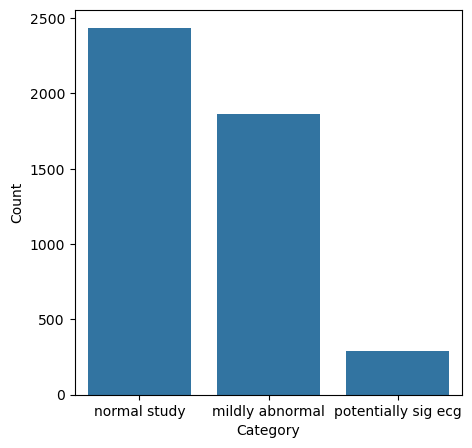

In [30]:
plt.figure(figsize=(5, 5))
c_counts = ldf["Overall Conclusion"].value_counts()
sns.barplot(x=c_counts.index, y=c_counts.values)
plt.xlabel("Category")
plt.ylabel("Count")

In [23]:
ab_ldf = ldf[ldf["ECG Interpretation"] == "abnormal"]

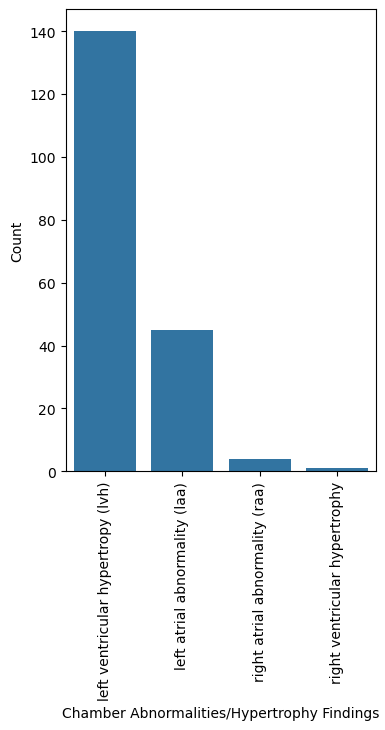

In [24]:
plt.figure(figsize=(4, 6))
sup_v_counts = ab_ldf["Chamber Abnormalities/Hypertrophy Findings"].value_counts()
sns.barplot(x=sup_v_counts.index, y=sup_v_counts.values)
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.show()